In [195]:
import numpy as np
import torch,torchvision
import matplotlib.pyplot as plt
%matplotlib widget

import torch
plt.set_loglevel('critical')

# Homework 4

Homework 4 will cover materials from chapter 8 (Image registration) and 9 (Statistical testing).

Ideally, computational, analytical, and written parts can be submitted as part of this jupyter notebook.

Homework should be submitted by email, to dtward@mednet.ucla.edu.

Coding parts can be submitted as part of the notebook, using as many cells as is convenient.

Analytical parts should be submitted with math rendered using Latex in markdown cells, using as many cells as is convenient.

Written parts can use markdown cells.

If you do not know how to type equations in Latex, and cannot work out enough of the basics using the equations provided here, please email me and we'll work something out.

There is lots of exposition in this homework assignment.  All the problems that need to be solved are labeled with the the title "Problem".

Homework will be due on Friday March 22 (one week from today).  There can be no extensions on homework 4.  If you cannot finish, please submit partial results.

# Part 1, Image registration

## Problem 1.1 Deformable image registration

Load the dataset of coronal MRI images.

Use the code provided to register one example image pair.

You may have to try several times to get good results.   You can experiment with:

* The smoothness kernel size: r

* The regularization strength: sigmaR

* The gradient descent step size: ep

* The numberof iterations: niter

An example of a "good" result is included as a figure.  

The green and red images should align well, but small errors are okay.  

The deformations should be not too "wiggly".  

The matching energy should reduce and approach a constant value.

The regularization energy should increase and approach a constant value.


Text(0.5, 1.0, 'Coronal MRI index 0, disease True')

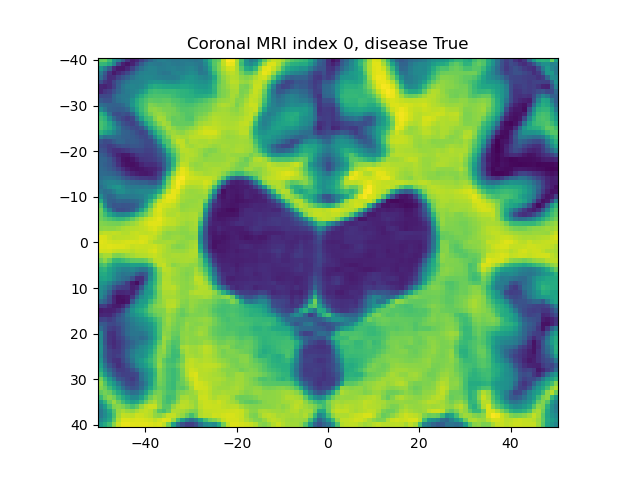

In [196]:
disease = np.load('disease.npy')
images = np.load('coronal_mri_images.npy')

d = 1.0
n = [images.shape[-2],images.shape[-1]]
x = [np.arange(ni)*d - (ni-1)*d/2 for ni in n]
extent = (x[1][0]-d/2,x[1][-1]+d/2, x[0][-1]+d/2, x[0][0]-d/2)
fig,ax = plt.subplots()
ind = 0
ax.imshow(images[ind],extent=extent)
ax.set_title(f'Coronal MRI index {ind}, disease {disease[ind]}')

In [197]:
# define interpolation in torch, 
# we need to use built in functions so torch can automatically compute gradients for optimization
# using their slightly different "grid sample" function
def interp(XI,I,XS):
    # sample points get mapped to the interval -1 to 1
    XS = (XS - XI[0,0])/(XI[-1,-1] - XI[0,0])
    XS = XS*2-1    
    # torch expects xy order insteady of row column order
    # so we flip our sample points on the last axis
    # it expects us to have a minibatch dimension, so we use [None] to add a minibatch dimension of size 1
    # and we use [0] to remove this extra dimension
    return torch.nn.functional.grid_sample(I[None],XS.flip(-1)[None],align_corners=True,)[0]

In [198]:
def phi_from_v(X,v,n=5):
    # we can build an invertible small deformation
    # by composing a large deformation with itself multiple times
    # we'll compute a position field phi,
    # we initialze it to (id + v*constant)
    phi = X + v/2**n
    # this approach is caled scaling and squaring
    # scaling means we divide by 2**n
    # and square means we compose it with itself.
    for i in range(n-1):      
        # compose it with itself using interpolation
        #phi = interp(X,phi.permute(-1,0,1),phi).permute(1,2,0)
        # use a trick, subtract and add identity so we can use the value 0 for extrapolation
        phi = interp(X,(phi-X).permute(-1,0,1),phi).permute(1,2,0) + phi
    return phi

In [199]:
# registration parameters to experiment with
r = 20
niter = 200
ep = 1e-2
sigmaR = 1e1

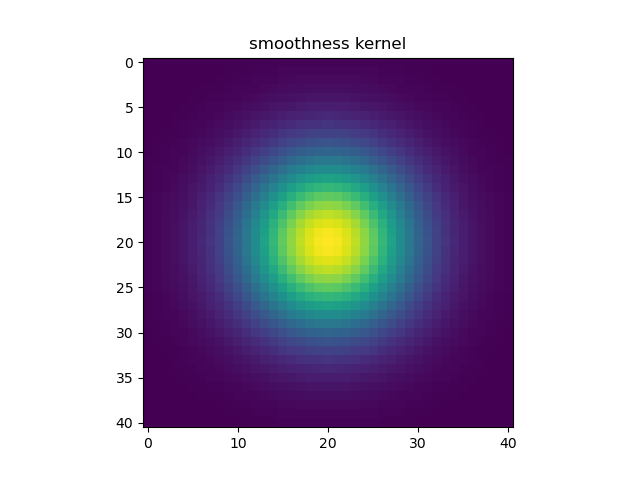

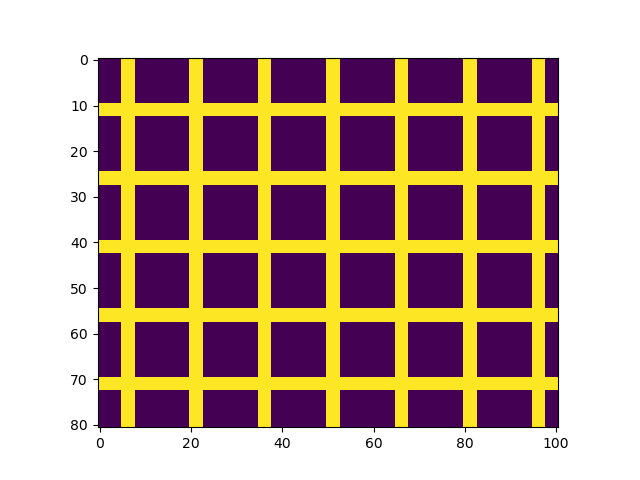

In [200]:
device = 'cpu'
dtype = torch.float64
Xt = torch.tensor(np.stack(np.meshgrid(*x,indexing='ij'),-1), device=device,dtype=dtype)


# smoothness kernel
sigma = r/3
x_ = torch.arange(-r,r+1,device=device,dtype=dtype)
xgrid = torch.stack(torch.meshgrid(x_,x_,indexing='ij'),-1)
k = torch.exp( -torch.sum(xgrid**2,-1)/2.0/sigma**2  )
fig,ax = plt.subplots()
ax.imshow(k.cpu())
# torch uses the following convention
# it uses a "convolution layer" instead of the "convolution operation"
k = torch.eye(2,device=device,dtype=dtype)[...,None,None]*k[None,None]
ax.set_title('smoothness kernel')

# grid
period = 15.0 # period 
thickness = 2.0 # draw lines with a thickness of 2
gridt = ((Xt[...,0]%period <= d*thickness) + (Xt[...,1]%period <= d*thickness)).to(dtype)
fig,ax = plt.subplots()
ax.imshow(gridt.cpu())

In [201]:
ind0 = 0
ind1 = 1
It = torch.tensor(images[ind0][None],device=device,dtype=dtype)
Jt = torch.tensor(images[ind1][None],device=device,dtype=dtype)

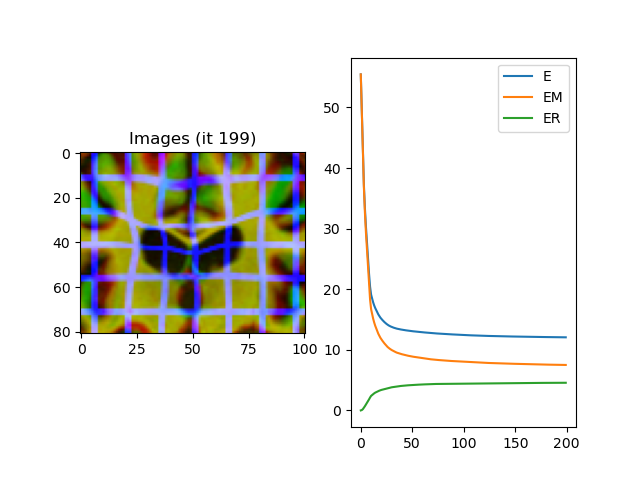

In [202]:
p = torch.zeros_like(Xt,requires_grad=True)

fig,ax = plt.subplots(1,2)

Esave = []
EMsave = []
ERsave = []
for it in range(niter):
    # clear gradients    
    if p.grad is not None: p.grad.zero_()
    
    # first compute v from p
    # we need to swap "vector components" with "channel components" to use this function
    v = torch.nn.functional.conv2d(p.permute(-1,0,1),k,padding=r).permute(1,2,0)    
    
    # compute the points to interpolate the image on   
    phii = phi_from_v(Xt,-v)
    # instead of writint Xt-v, we use the position field computed by scaling and squaring
        
    # apply the transformation through interpolation
    phiI = interp(Xt,It,phii)
    
    # calculate the loss function
    # for matching, instead of sum of square error, we will focus only on pixels near the ventricles
    # and not on those near the boundary
    EM = 0.5*torch.sum( (phiI-Jt)[:,20:-20,20:-20]**2 )*d**2
    # regularization
    ER = 0.5 * torch.sum( v*p  )/sigmaR**2*d**2
    E = EM+ER
    Esave.append(E.item())
    ERsave.append(ER.item())
    EMsave.append(EM.item())
    E.backward()
    
    # update parameters with gradient descent        
    p.data -= ep*p.grad
    
    with torch.no_grad():
        if not it%10 or it == niter-1:
            Agrid = interp(Xt,gridt[None],phii)
            ax[0].cla()
            ax[0].imshow( torch.concatenate((phiI,Jt,Agrid)).permute(1,2,0).cpu() )
            ax[0].set_title(f'Images (it {it})')

            ax[1].cla()
            ax[1].plot(Esave,label='E')
            ax[1].plot(EMsave,label='EM')
            ax[1].plot(ERsave,label='ER')
            ax[1].legend()
            fig.canvas.draw()
        
# when you save the output v to a list, you will want to detach it from the computation graph to free up some memory
v = v.clone().detach()        
    

## Problem 1.2, batch image registration

Chose a single image as a "template".

Using the parameters you identified above, register the template (It) to each target (Jt) including itself.

You may want to wrap the above code into a function, or just loop over them.

Save the resulting vector fields $v$s in a list.  Make sure they are detached from the computation graph (v.clone().detach()).

In [203]:
def image_registration(It, Jt, graph=False) -> torch.Tensor:
    # instantiate coefficients at each point
    p = torch.zeros_like(Xt,requires_grad=True)

    if graph:
        fig,ax = plt.subplots(1,2)

        Esave = []
        EMsave = []
        ERsave = []
    for it in range(niter):
        # clear gradients    
        if p.grad is not None: p.grad.zero_()
        
        # first compute v from p
        # we need to swap "vector components" with "channel components" to use this function
        v = torch.nn.functional.conv2d(p.permute(-1,0,1),k,padding=r).permute(1,2,0)    
        
        # compute the points to interpolate the image on   
        phii = phi_from_v(Xt,-v)
        # instead of writint Xt-v, we use the position field computed by scaling and squaring
            
        # apply the transformation through interpolation
        phiI = interp(Xt,It,phii)
        
        # calculate the loss function
        # for matching, instead of sum of square error, we will focus only on pixels near the ventricles
        # and not on those near the boundary
        EM = 0.5*torch.sum( (phiI-Jt)[:,20:-20,20:-20]**2 )*d**2
        # regularization
        ER = 0.5 * torch.sum( v*p  )/sigmaR**2*d**2
        E = EM+ER
        
        # Save errors only if we want to graph
        if graph:
            Esave.append(E.item())
            ERsave.append(ER.item())
            EMsave.append(EM.item())
        E.backward()
        
        # update parameters with gradient descent        
        p.data -= ep*p.grad
        
        # Only perform graphing math and output if needed
        if graph:
            with torch.no_grad():
                if not it%10 or it == niter-1:
                    Agrid = interp(Xt,gridt[None],phii)
                    ax[0].cla()
                    ax[0].imshow( torch.concatenate((phiI,Jt,Agrid)).permute(1,2,0).cpu() )
                    ax[0].set_title(f'Images (it {it})')

                    ax[1].cla()
                    ax[1].plot(Esave,label='E')
                    ax[1].plot(EMsave,label='EM')
                    ax[1].plot(ERsave,label='ER')
                    ax[1].legend()
                    fig.canvas.draw()
            
    # when you save the output v to a list, you will want to detach it from the computation graph to free up some memory
    v = v.clone().detach()        
    return v
    

In [204]:
from tqdm import tqdm
It = torch.tensor(images[ind0][None],device=device,dtype=dtype)
vs = []
for J in tqdm(images):
    Jt = torch.tensor(J[None], device=device, dtype=dtype)
    v_ = image_registration(It, Jt, graph=False)
    vs.append(v_)

100%|██████████| 11/11 [05:07<00:00, 27.91s/it]


# Part 2, Statistical testing and morphometry

## 2.1 Determinant of Jacobian

For each of the vector fields $v$ that you saved, compute the log of the determinant of Jacobian of the resulting deformations phi.

This quantity says how much growth or shrinkage each brain exhibits, relative to your template.  It is used to study neurodegeneration.


If you were not able to compute good registrations, you can use the provided data instead (vstack.npy).

Note: above we calculated phi inverse, here you should calculate phi instead.

You can use the torch.gradient function to compute derivatives in the row and column dimension.

You can use the torch.linalg.det function to compute the determinant of Jacobian.

Show an image of the log determinant of Jacobian for each individual.

In [205]:
def jacobian(phi):
    grad_x = torch.gradient(phi[:, :, 0])
    grad_y = torch.gradient(phi[:, :, 1])

    jac = torch.zeros((phi.shape[0], phi.shape[1], 2, 2))
    jac[:, :, 0, 0] = grad_x[1]
    jac[:, :, 0, 1] = grad_x[0]
    jac[:, :, 1, 0] = grad_y[1]
    jac[:, :, 1, 1] = grad_y[0]
    return jac

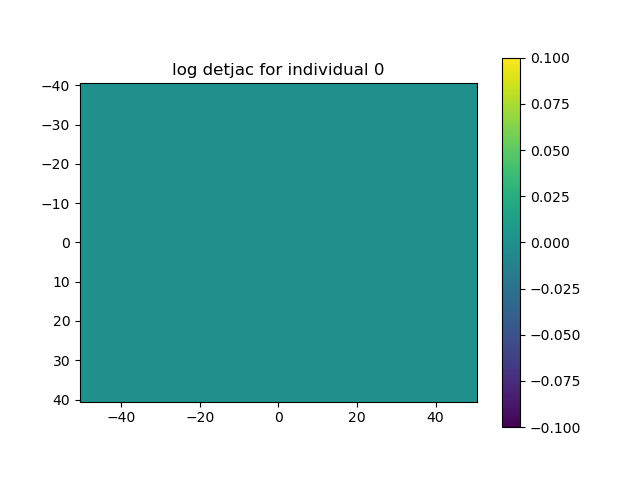

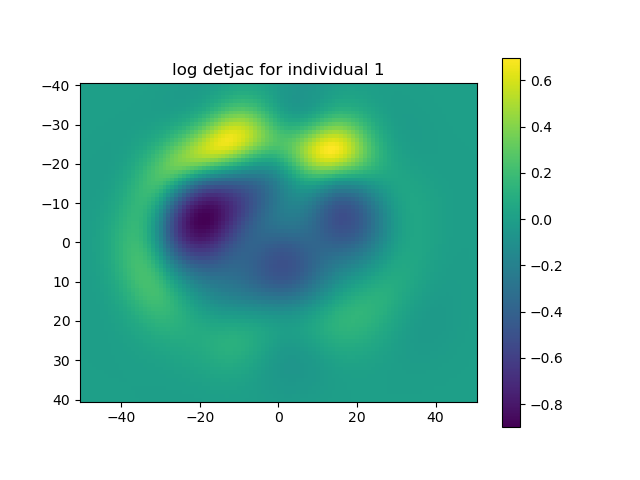

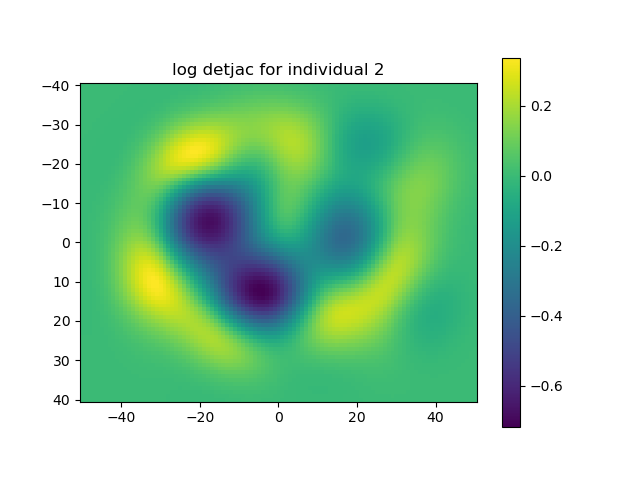

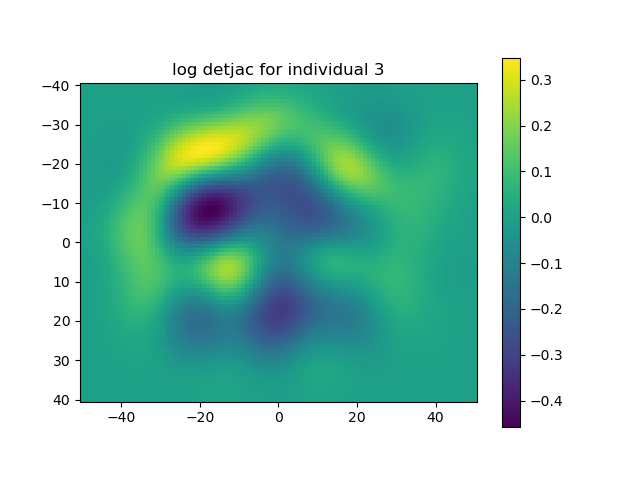

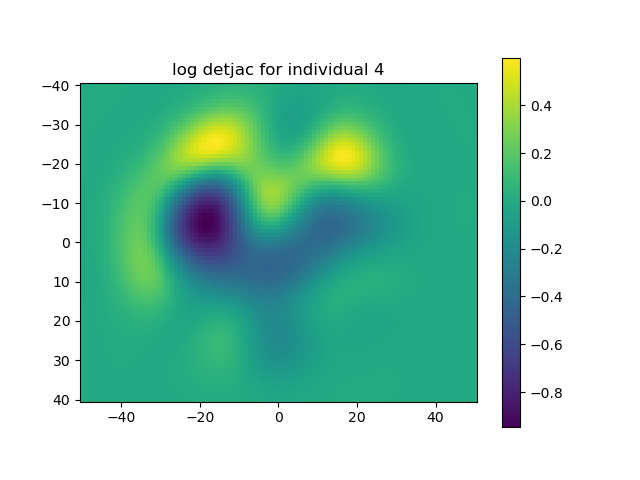

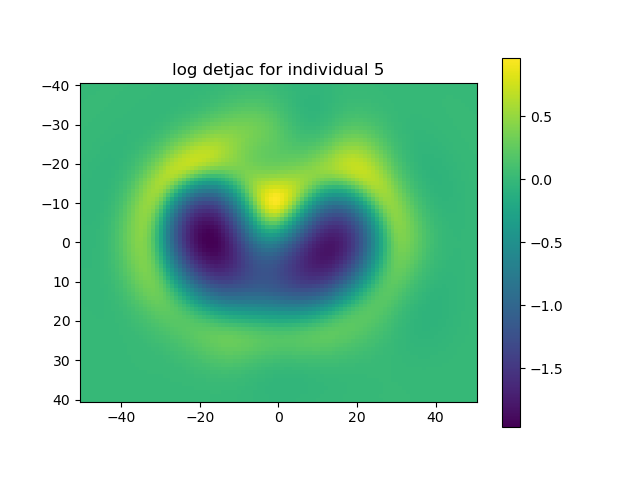

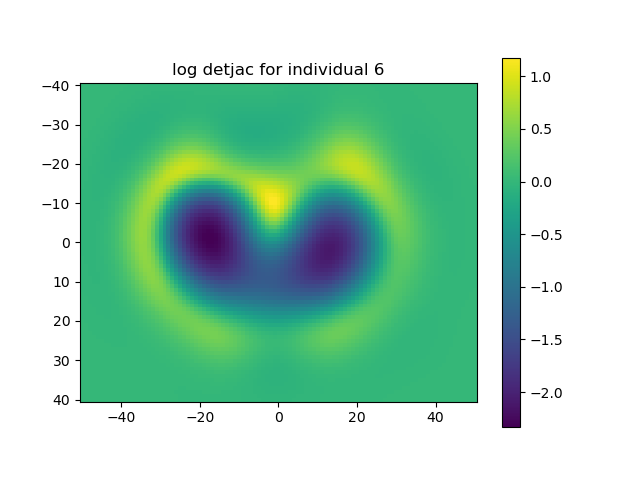

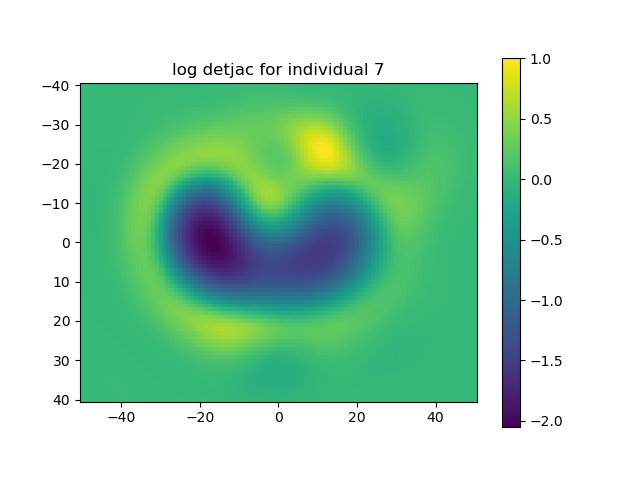

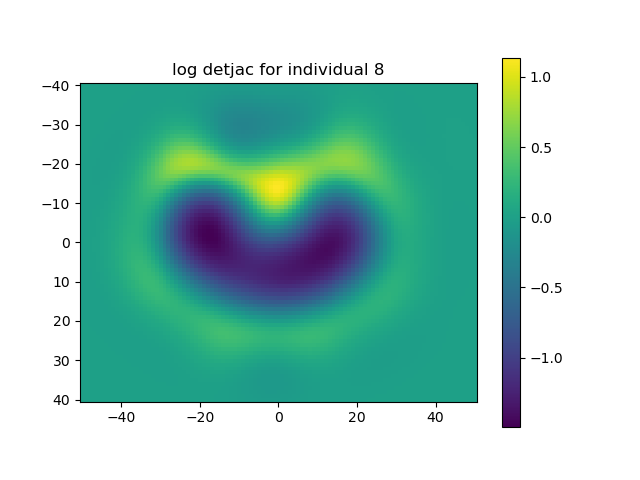

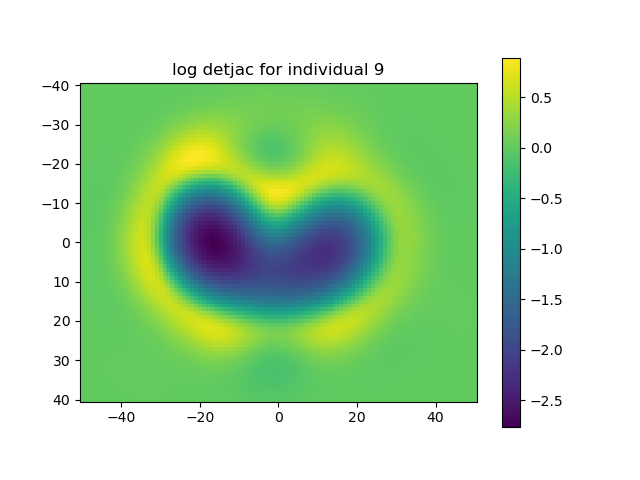

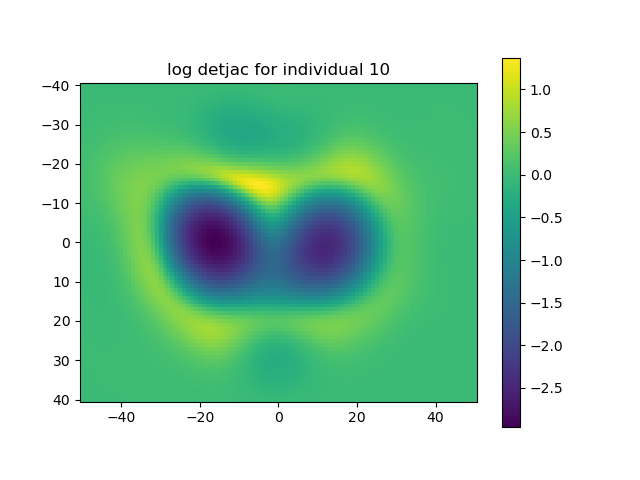

In [206]:
log_dets = []
for ind,v in enumerate(vs):
    phi = phi_from_v(Xt, v) # use positive v instead of negative v to get phi not phi inverse
    # phi now maps every point from the original image to where it belongs in the transformed version
    jac = jacobian(phi)

    log_det = torch.log(np.abs(torch.linalg.det(jac)))
    log_dets.append(log_det)

    fig, ax = plt.subplots()
    h = ax.imshow(log_det,extent=extent)
    fig.colorbar(h)
    ax.set_title(f'log detjac for individual {ind}')



## Problem 2.2, statistical testing

Test the alternate hypothesis that the determinant of Jacobian depends on disease, versus the null hypothesis that it does not.

You will fit two models at each pixel.  Let $y_{ij}$ be the log determinant of Jacobian at pixel $i$ for individual $j$.  Then you will fit $y_{ij} = a_i + b_i \text{disease}_j + \epsilon_{ij}$ for the alternate hypothesis, and $y_{ij} = a_i + \epsilon_{ij}$  for the null hypothesis.  

Compute the unknown parameters by least squares, and compute the sum of square error at each pixel under each model: $SSE_1$ and $SSE_0$.

Use a test statistic at each pixel given by $SSE_0/(SSE_1 + 1)$. We will add the 1 to the denominator to avoid potential "divide by zero errors".


Use permutation testing, by randomly permuting the disease labels for 1000 permutations. Use the maximum statistic to control the FWER across each pixel at 5%.

What is the FWER controled p value?

Compute a threshold as the 95th percentile of the maximum of the permuted test statistics.  Visualize an image of which pixels you can reject the null hypothesis at.  

In [207]:
y = np.stack(log_dets).transpose(1,2,0)
print(y.shape)


(81, 101, 11)


Text(0.5, 1.0, 'Sum of square error at each pixel for model 1')

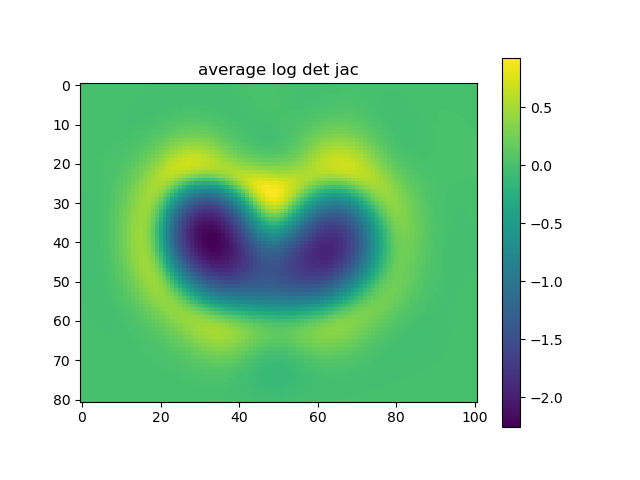

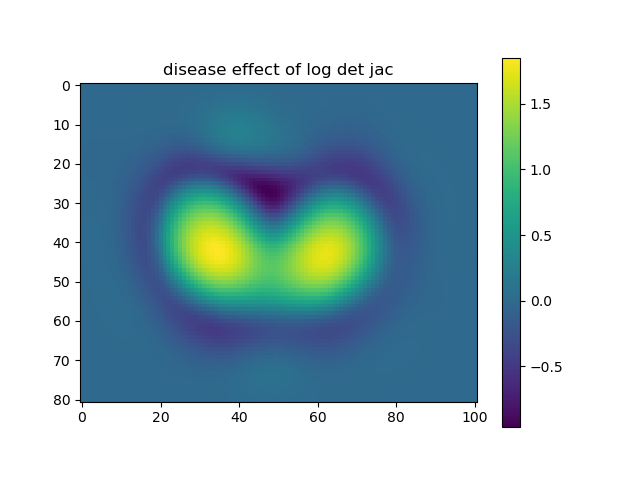

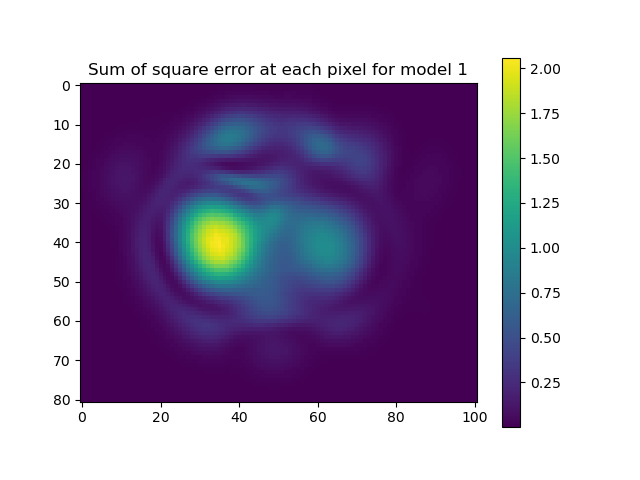

In [326]:
# here is an example of fitting the alternate hypothesis
# we assume y is a 81x101x11 numpy array
# if your y is 11x81x101 you'll have to transpose it: y = y_old.transpose(1,2,0)

# build the design matrix matrix 
D = np.stack((np.ones(len(images)), disease))
# solve for the unknown coefficients with least squares
coeffs = np.linalg.solve(D@D.T, (y@D.T)[...,None] )[...,0]

fig,ax = plt.subplots()
h = ax.imshow(coeffs[...,0])
fig.colorbar(h)
ax.set_title('average log det jac')

fig,ax = plt.subplots()
h = ax.imshow(coeffs[...,1])
fig.colorbar(h)
ax.set_title('disease effect of log det jac')


# compute yhat, the data predicted by our model
# we will use this for goodness of fit tests
yhat = coeffs@D
sse1 = np.sum((yhat - y)**2,-1)
fig,ax = plt.subplots()
h = ax.imshow(sse1)
fig.colorbar(h)
ax.set_title('Sum of square error at each pixel for model 1')

Text(0.5, 1.0, 'Sum of square error at each pixel for model 0')

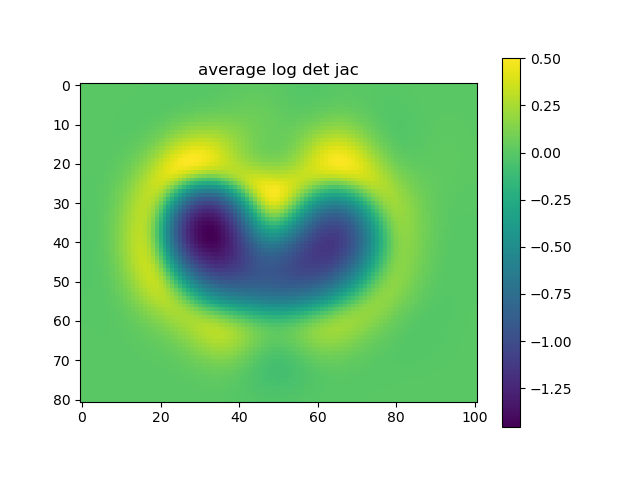

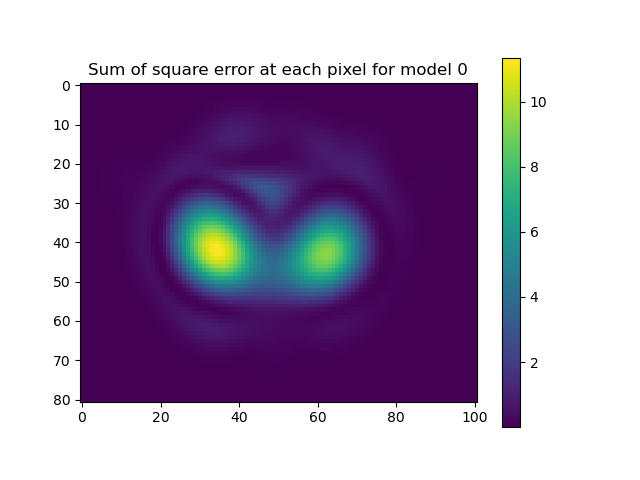

In [209]:
# fitting the null hypothesis
# y is an 81x101x11

# build the design matrix matrix 

D = np.ones((1, len(images)))

# solve for the unknown coefficients with least squares
coeffs = np.linalg.solve(D@D.T, (y@D.T)[...,None] )[...,0]

fig,ax = plt.subplots()
h = ax.imshow(coeffs[...,0])
fig.colorbar(h)
ax.set_title('average log det jac')

# compute yhat, the data predicted by our model
# we will use this for goodness of fit tests
yhat = coeffs@D
sse0 = np.sum((yhat - y)**2,-1)
fig,ax = plt.subplots()
h = ax.imshow(sse0)
fig.colorbar(h)
ax.set_title('Sum of square error at each pixel for model 0')

Text(0.5, 1.0, 'Test statistic at each pixel')

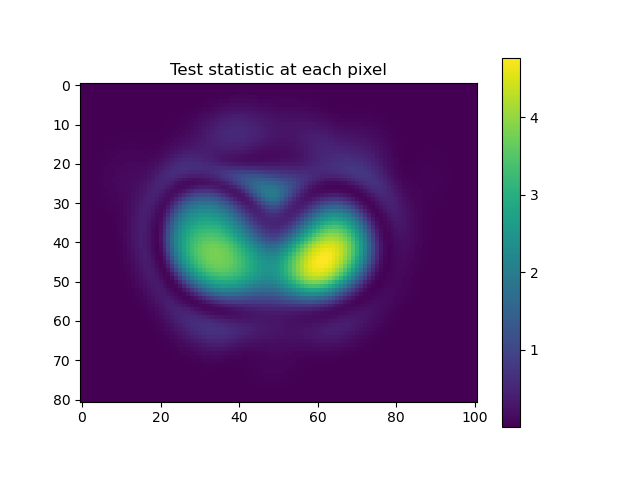

In [210]:
# here we show the test statistic
fig,ax = plt.subplots()
h = ax.imshow(sse0/(sse1+1))
fig.colorbar(h)
ax.set_title('Test statistic at each pixel')


In [233]:
# here do your permutation testing
# ...
Tstar = sse0/(sse1+1)
Tstarmax = np.max(Tstar)
nperm = 1000
Tpermmax = []
Puncorrected = np.zeros_like(images[0]*1.0)
Pfwer = np.zeros_like(images[0]*1.0)

for it in range(nperm):
    disease_p = np.random.permutation(disease)

    if it == 0:
        # Fit Null Hypothesis (Permutation invariant so only calc once)
        D0 = np.ones((1, len(images)))
        coeffs0 = np.linalg.solve(D0@D0.T, (y@D0.T)[...,None] )[...,0]
        yhat0 = coeffs0@D0
        sse0_p = np.sum((yhat0 - y)**2,-1)
    
    D1 = np.stack((np.ones(len(images)), disease_p))
    coeffs1 = np.linalg.solve(D1@D1.T, (y@D1.T)[...,None] )[...,0]
    yhat1 = coeffs1@D1
    sse1_p = np.sum((yhat1 - y)**2,-1)
    
    Tperm = sse0_p/(sse1_p+1)

    Tpermmax.append(np.max(Tperm))

    Puncorrected += (Tperm >= Tstarmax) * 1.0
    Pfwer += (np.max(Tperm) >= Tstarmax) * 1.0
    
Puncorrected /= nperm
Pfwer /= nperm


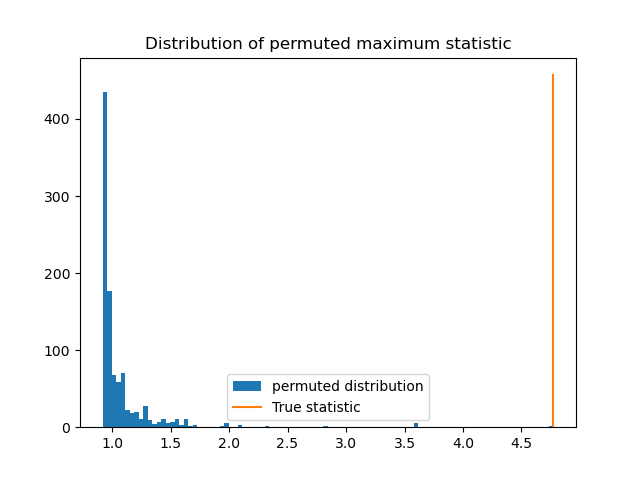

In [234]:
# here we show a histogram of permuted maximum statistics, as compared to the observed maximum statistic
fig,ax = plt.subplots()
ax.hist(Tpermmax,100,label='permuted distribution')
ax.set_title('Distribution of permuted maximum statistic')
ax.plot([Tstarmax,Tstarmax], ax.get_ylim(),label='True statistic')
ax.legend()

In [235]:
# here we print out the p value for this example
pvalue = np.mean(np.array(Tpermmax) >= Tstarmax)
print(pvalue)

0.002


Text(0.5, 1.0, 'Red: Significant morphological differences')

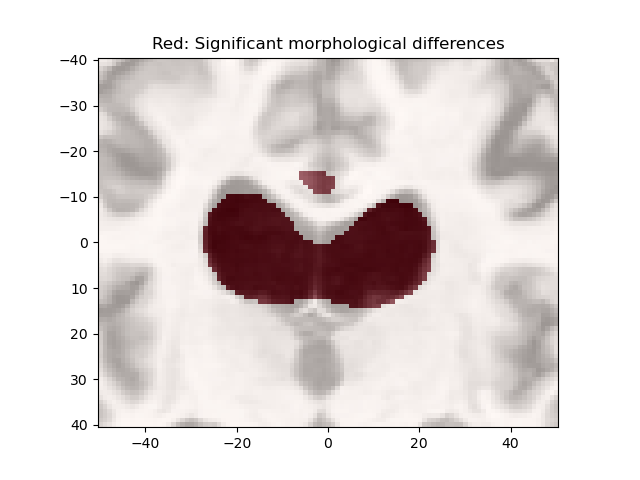

In [339]:
# here is an example of which pixels have a test statistic greater than the significance threshold
# calc threshold
t = np.quantile(Tpermmax,0.95)


fig,ax = plt.subplots()
base_image = images[0]

ax.imshow(base_image, alpha=1, extent=extent, cmap='Greys_r') 
#show the image with reduced alpha

# statistically significant pixels:
sig_pxls = (Tstar>t)

ax.imshow(sig_pxls, alpha=0.6, extent=extent, cmap='Reds')

ax.set_title("Red: Significant morphological differences")
